# ZADANIE 1

ES(μ + λ)
- no crossover (dzieci to podzbiór rodziców, który potem zmutujemy)
- choosing next population from children & parents
- took care of domain and variance explosion

ES(μ, λ)
- parents selection => roulette
- one point crossover
- choosing next population just from children



In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ES(μ + λ)

In [29]:
def population_evaluation(p, f):
    values = [f(i) for i in p[0]]
    return np.array(values)

def parent_selection(p, l, f_vals):
    indices = np.argsort(f_vals)[:l]
    selected_x = [p[0][i] for i in indices]
    selected_sigma = [p[1][i] for i in indices]
    return [selected_x, selected_sigma]



def mutation(p, t, t_0, lower_bound, upper_bound):
    x, sigma = p[0], p[1]
    epsilon_0 = random.gauss(0, t_0)
    sigma = [[max(1e-4, i * np.exp(epsilon_0 + random.gauss(0, t))) for i in s] for s in sigma]
    x = [
        [
            np.clip(x[i][dim] + random.gauss(0, sigma[i][dim]), lower_bound, upper_bound)
            for dim in range(len(x[i]))
        ]
        for i in range(len(x))
    ]
    return [x, sigma]

def ES_1(m, l, t, d, t0, f, T, random_population, lower_bound, upper_bound):
    p = random_population(m, d)
    f_vals = population_evaluation(p, f)
    best_solution, best_function_value = None, float('inf')
    function_value_history = []

    for generation in range(T):
        p_c = parent_selection(p, l, f_vals)
        p_c_mutated = mutation(p_c, t, t0, lower_bound, upper_bound)
        combined_x = p[0] + p_c_mutated[0]
        combined_sigma = p[1] + p_c_mutated[1]
        combined_population = [combined_x, combined_sigma]
        f_vals_combined = population_evaluation(combined_population, f)
        combined_population_with_function_values = list(zip(combined_x, combined_sigma, f_vals_combined))
        combined_population_sorted = sorted(combined_population_with_function_values, key=lambda x: x[2])
        selected_combined_x = [individual[0] for individual in combined_population_sorted[:m]]
        selected_combined_sigma = [individual[1] for individual in combined_population_sorted[:m]]
        p = [selected_combined_x, selected_combined_sigma]

        for i in range(m):
            current_function_value = combined_population_sorted[i][2]
            if current_function_value < best_function_value:
                best_function_value = current_function_value
                best_solution = combined_population_sorted[i][0]

        function_value_history.append(best_function_value)

        print(f"Generation {generation + 1}, Best Function Value: {best_function_value}")

    plt.plot(range(1, T + 1), function_value_history, label="Best Function Value")
    plt.xlabel("Generation")
    plt.ylabel("Function Value")
    plt.yscale("log")
    plt.title("Function Value Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

    return best_solution, best_function_value



In [30]:
# ES(μ, λ)

In [35]:
def parent_selection_roulette(p, l, f_vals):
    inverted_vals = 1 / (f_vals + 1e-9)
    probabilities = inverted_vals / np.sum(inverted_vals)
    indices = np.random.choice(len(f_vals), size=l, replace=True, p=probabilities)
    selected_x = [p[0][i] for i in indices]
    selected_sigma = [p[1][i] for i in indices]
    return [selected_x, selected_sigma]

def crossover(parents, crossover_rate=0.9):
    x, sigma = parents[0], parents[1]
    num_parents = len(x)
    num_children = num_parents // 2 
    
    children_x = []
    children_sigma = []

    for _ in range(num_children):
        if random.random() < crossover_rate:
            parent1_idx, parent2_idx = random.sample(range(num_parents), 2)
            parent1_x, parent2_x = x[parent1_idx], x[parent2_idx]
            parent1_sigma, parent2_sigma = sigma[parent1_idx], sigma[parent2_idx]
            
            child1_x = [(p1 + p2) / 2 for p1, p2 in zip(parent1_x, parent2_x)]
            child2_x = [(p1 - p2) / 2 + random.choice([p1, p2]) for p1, p2 in zip(parent1_x, parent2_x)]

            child1_sigma = [(s1 + s2) / 2 for s1, s2 in zip(parent1_sigma, parent2_sigma)]
            child2_sigma = [(s1 - s2) / 2 + random.choice([s1, s2]) for s1, s2 in zip(parent1_sigma, parent2_sigma)]
            
            children_x.extend([child1_x, child2_x])
            children_sigma.extend([np.clip(child1_sigma, 1e-4, 1), np.clip(child2_sigma, 1e-4, 1)])
        else:
            parent_idx = random.randint(0, num_parents - 1)
            children_x.append(x[parent_idx])
            children_sigma.append(sigma[parent_idx])
    
    return [children_x, children_sigma]

def mutation(p, t, t_0, lower_bound, upper_bound):
    x, sigma = p[0], p[1]
    epsilon_0 = random.gauss(0, t_0)
    sigma = [
        [
            max(1e-4, min(1, i * np.exp(epsilon_0 + random.gauss(0, t))))
            for i in s
        ]
        for s in sigma
    ]
    x = [
        [
            np.clip(x[i][dim] + random.gauss(0, sigma[i][dim]), lower_bound, upper_bound)
            for dim in range(len(x[i]))
        ]
        for i in range(len(x))
    ]
    return [x, sigma]

def ES_2(m, l, t, d, t0, f, T, random_population, lower_bound, upper_bound, crossover_rate=0.9):
    p = random_population(m, d)
    f_vals = population_evaluation(p, f)
    best_solution, best_fitness = None, float('inf')
    fitness_history = []

    for generation in range(T):
        parents = parent_selection_roulette(p, l, f_vals)
        children = crossover(parents, crossover_rate)
        mutated_children = mutation(children, t, t0, lower_bound, upper_bound)
        f_vals_children = population_evaluation(mutated_children, f)
        p = mutated_children
        f_vals = f_vals_children

        current_best_fitness = min(f_vals)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = mutated_children[0][np.argmin(f_vals)]
        
        fitness_history.append(best_fitness)
        print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, T + 1), fitness_history, label="Best Fitness")
    plt.yscale("log")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (log scale)")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

    return best_solution, best_fitness



### ACKLEY ES(μ + λ), ES(μ, λ)

In [17]:
def ackley_function(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    term1 = -a * np.exp(-b * np.sqrt(np.sum(np.square(x)) / d))
    term2 = -np.exp(np.sum(np.cos(c * np.array(x))) / d)
    return term1 + term2 + a + np.exp(1)

def random_population_ackley(m, d):
    x = [[random.uniform(-15, 30) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 0.3) for _ in range(d)] for _ in range(m)]
    return [x, sigma]


Generation 1, Best Function Value: 19.477489077331217
Generation 2, Best Function Value: 19.29127711851189
Generation 3, Best Function Value: 19.29127711851189
Generation 4, Best Function Value: 19.29127711851189
Generation 5, Best Function Value: 19.29127711851189
Generation 6, Best Function Value: 19.29127711851189
Generation 7, Best Function Value: 19.29127711851189
Generation 8, Best Function Value: 19.29127711851189
Generation 9, Best Function Value: 19.271715946815213
Generation 10, Best Function Value: 19.271715946815213
Generation 11, Best Function Value: 19.271640720024518
Generation 12, Best Function Value: 19.123306097368943
Generation 13, Best Function Value: 19.123306097368943
Generation 14, Best Function Value: 19.123306097368943
Generation 15, Best Function Value: 19.123306097368943
Generation 16, Best Function Value: 19.123306097368943
Generation 17, Best Function Value: 19.123306097368943
Generation 18, Best Function Value: 19.123306097368943
Generation 19, Best Functi

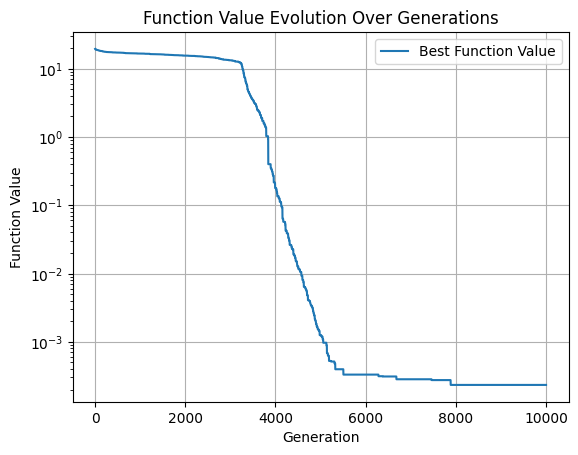

Best Solution: [4.685228116599227e-05, 0.0001034931551624994, -4.900358476409212e-06, -2.537659049099682e-05, 4.441733097219418e-06, -0.00011457353887370135, 8.816204022081695e-05, 8.116293232944929e-05, 1.0291712888497339e-05, 5.56913325945662e-05, -2.274717529861983e-05, 5.4074957015213697e-05, -6.36479424927623e-05, -3.654401371676677e-05, 2.954420129136132e-05, 3.243894391793553e-05, 3.6007034032872474e-06, -8.648610923945224e-07, -0.00011331506749955134, 1.3084796750657799e-05], Best Function Value: 0.00023353355861788216


In [18]:
m = 100
l = 20
t = np.log(0.1)
t0 = np.log(0.01)
d = 20 
T = 10000
lower_bound=-15
upper_bound=30

best_solution, best_function_value = ES_1(m, l, t, d, t0, ackley_function, T, random_population_ackley, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Function Value: {best_function_value}")

Generation 1, Best Fitness: 14.967017568910018
Generation 2, Best Fitness: 13.59801956184087
Generation 3, Best Fitness: 13.59801956184087
Generation 4, Best Fitness: 13.59801956184087
Generation 5, Best Fitness: 13.59801956184087
Generation 6, Best Fitness: 13.59801956184087
Generation 7, Best Fitness: 13.59801956184087
Generation 8, Best Fitness: 13.59801956184087
Generation 9, Best Fitness: 13.59801956184087
Generation 10, Best Fitness: 13.59801956184087
Generation 11, Best Fitness: 13.59801956184087
Generation 12, Best Fitness: 13.59801956184087
Generation 13, Best Fitness: 13.59801956184087
Generation 14, Best Fitness: 13.59801956184087
Generation 15, Best Fitness: 13.59801956184087
Generation 16, Best Fitness: 13.59801956184087
Generation 17, Best Fitness: 13.249991696345594
Generation 18, Best Fitness: 13.249991696345594
Generation 19, Best Fitness: 13.249991696345594
Generation 20, Best Fitness: 13.249991696345594
Generation 21, Best Fitness: 13.249991696345594
Generation 22, B

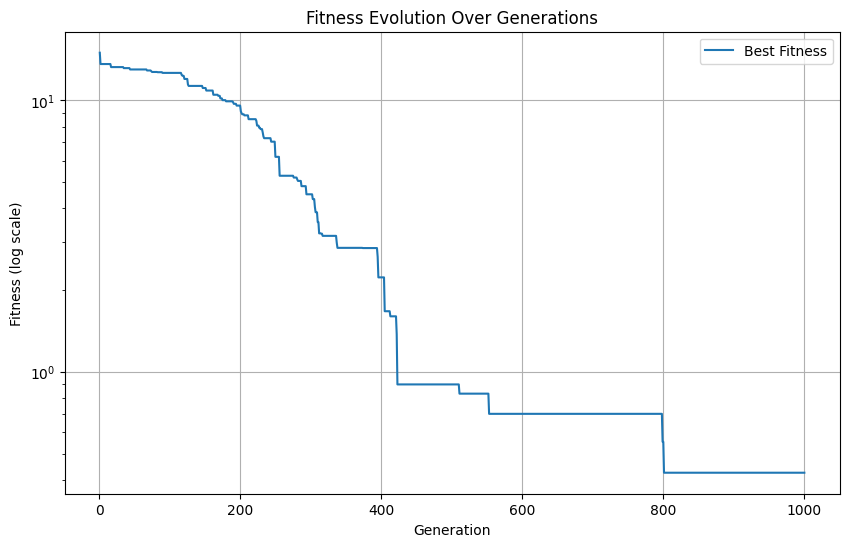

Best Solution: [0.03223749672719818, 0.09656871340448772, 0.018578322354200028, 0.08666949623759967, 0.058569576738503916, -0.018341060844829535, 0.032297952911614955, -0.06253789892431057, 0.02729527221392284, -0.03028210957500207, -0.08563028349040432, -0.03727730243800965, 0.0077827869616413, 0.08841183202235957, 0.06409803537699395, 0.013945635698927341, 0.07960340675316997, 0.022990873910186907, -0.12353262753217542, -0.039134044881677627], Best Function Value: 0.4251109400032367


In [29]:
m = 1000
l = 8000
t = np.log(0.2)
t0 = np.log(0.1)
d = 20 
T = 1000
lower_bound=-15
upper_bound=30

best_solution, best_function_value = ES_2(m, l, t, d, t0, ackley_function, T, random_population_ackley, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Function Value: {best_function_value}")

- w ES(μ, λ) trzeba było znacząco zwiększyć rozmiar populacji aby znaleźć sensowne przybliżenie rozwiązania
- funkcja dla ES(μ, λ) bardziej schodkowa, jak wszystkie dzieci są zepsute to długo czekamy aby jakieś sensowne dziecko się zmutowało

### GIERWANK ES(μ + λ)

Generation 1, Best Function Value: 241.0329678490006
Generation 2, Best Function Value: 241.0329678490006
Generation 3, Best Function Value: 241.0329678490006
Generation 4, Best Function Value: 241.032680929482
Generation 5, Best Function Value: 240.35245972928806
Generation 6, Best Function Value: 240.35245972928806
Generation 7, Best Function Value: 239.82329663838945
Generation 8, Best Function Value: 239.82329663838945
Generation 9, Best Function Value: 239.82329663838945
Generation 10, Best Function Value: 239.81909439041715
Generation 11, Best Function Value: 239.78465083906954
Generation 12, Best Function Value: 239.35058839719932
Generation 13, Best Function Value: 239.35058839719932
Generation 14, Best Function Value: 238.86835098205847
Generation 15, Best Function Value: 238.8669355785368
Generation 16, Best Function Value: 238.69458722940735
Generation 17, Best Function Value: 238.69458722940735
Generation 18, Best Function Value: 238.69458722940735
Generation 19, Best Funct

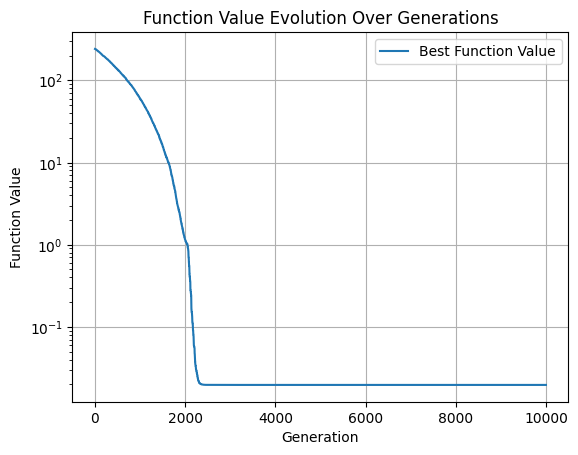

Best Solution: [3.332390394012593e-06, -4.438424723045342, 2.7091841127864552e-05, -5.677682286554511e-06, -8.607121504243879e-06, 7.672237078446046, -3.074913623958205e-05, 4.828815159022428e-05, -2.644431128076332e-05, -1.2086656008735173e-05, -9.48855274555171e-06, 6.64604561814767e-05, -1.8363560950398254e-05, 8.051813208072834e-05, 5.658722680447246e-06, -0.00011777197620626554, 7.045862125933028e-05, -0.00012705831916479918, 2.829235716286256e-05, -1.8750932777890608e-05], Best Fitness: 0.019690000170177302


In [15]:
def griewank_function(x):
    sum_term = sum([i**2 for i in x]) / 4000
    product_term = np.prod([np.cos(i / np.sqrt(idx + 1)) for idx, i in enumerate(x)])
    return 1 + sum_term - product_term


def random_population_griewank(m, d):
    x = [[random.uniform(-600, 600) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 0.3) for _ in range(d)] for _ in range(m)]
    return [x, sigma]



m = 1000
l = 800
t = np.log(0.5)
t0 = np.log(0.01)
d = 20
T = 10000
lower_bound=-600
upper_bound=600

best_solution, best_fitness = ES_1(m, l, t, d, t0, griewank_function, T, random_population_griewank, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

### GIERWANK ES(μ, λ)

Generation 1, Best Fitness: 83.25140007839012
Generation 2, Best Fitness: 29.643237022091203
Generation 3, Best Fitness: 14.946333382723429
Generation 4, Best Fitness: 8.691543928645672
Generation 5, Best Fitness: 5.247065378720257
Generation 6, Best Fitness: 3.5648868605791955
Generation 7, Best Fitness: 2.50565183437814
Generation 8, Best Fitness: 1.7421991288494787
Generation 9, Best Fitness: 1.508813411881729
Generation 10, Best Fitness: 1.379180941850751
Generation 11, Best Fitness: 1.22861337425779
Generation 12, Best Fitness: 1.165052759183001
Generation 13, Best Fitness: 1.1272807774179612
Generation 14, Best Fitness: 1.0989040151149536
Generation 15, Best Fitness: 1.086794335556182
Generation 16, Best Fitness: 1.075920706494373
Generation 17, Best Fitness: 1.064593632261971
Generation 18, Best Fitness: 1.0585035194444647
Generation 19, Best Fitness: 1.0585035194444647
Generation 20, Best Fitness: 1.0585035194444647
Generation 21, Best Fitness: 1.0555784930208694
Generation 22,

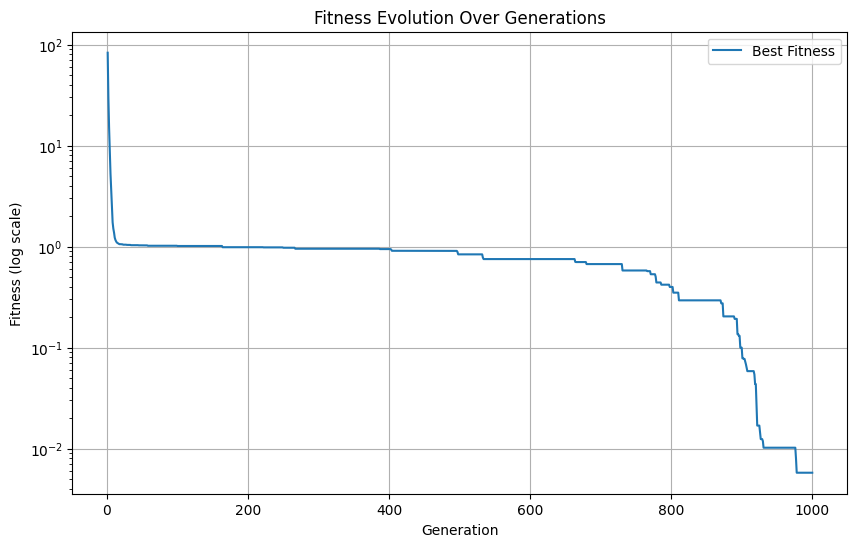

Best Solution: [0.050740062632573045, 0.02372402898021421, 0.08024200444736886, -0.0026927393967420554, 0.01803546405510072, -0.07803362659665089, -0.07080093156013677, -0.005153679633554335, -0.1090347329484989, 0.03911060952759063, -0.02421187031089434, 0.0874463313554552, 0.13079612848269132, 0.10066792567658082, -0.04517389916597808, -0.013271951217582803, 0.045434062592504425, -0.06343459926113487, -0.01631907122941575, -0.028129753575667306], Best Fitness: 0.005781258077056428


In [8]:
m = 1000
l = 8000
t = np.log(0.8)
t0 = np.log(0.2)
d = 20
T = 1000
lower_bound=-600
upper_bound=600
best_solution, best_fitness = ES_2(m, l, t, d, t0, griewank_function, T, random_population_griewank, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

### ROSENBROCK ES(μ, λ)

Generation 1, Best Function Value: 372719.687902294
Generation 2, Best Function Value: 372719.687902294
Generation 3, Best Function Value: 348028.10014534736
Generation 4, Best Function Value: 333228.3432012401
Generation 5, Best Function Value: 230786.2871261406
Generation 6, Best Function Value: 230786.2871261406
Generation 7, Best Function Value: 230786.2871261406
Generation 8, Best Function Value: 162743.14414656317
Generation 9, Best Function Value: 162743.14414656317
Generation 10, Best Function Value: 159204.165270857
Generation 11, Best Function Value: 130876.99006401974
Generation 12, Best Function Value: 120478.94632653437
Generation 13, Best Function Value: 85780.12856502838
Generation 14, Best Function Value: 85780.12856502838
Generation 15, Best Function Value: 85780.12856502838
Generation 16, Best Function Value: 82499.03004599366
Generation 17, Best Function Value: 79349.14744865237
Generation 18, Best Function Value: 55908.98008256468
Generation 19, Best Function Value:

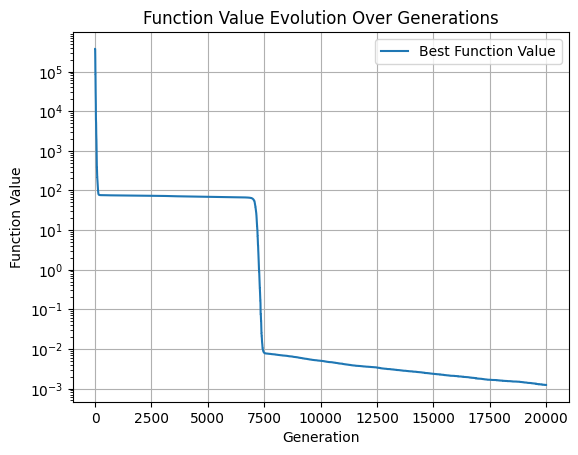

Best Solution: [0.9999455103142935, 1.0000707729251348, 0.9999751633264029, 1.0000960905803313, 1.0000149497787825, 1.0000787999862597, 1.0000519471227647, 1.0000607612599657, 1.000048506936095, 1.0000464925530659, 1.0001165190941452, 1.0002220569144813, 1.0004389051990048, 1.0008569674403072, 1.0018188212014283, 1.0037485438102034, 1.0073269634888657, 1.0147887209240605, 1.030029363281762, 1.061343205980639], Best Fitness: 0.0012326266560015809


In [57]:
def rosenbrock_function(x):
    d = len(x)
    sum = 0.0
    for i in range(d-1):
        sum += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return sum


def random_population_rosenbrock(m, d, lower_bound=-5, upper_bound=10):
    population = [[random.uniform(lower_bound, upper_bound) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 0.3) for _ in range(d)] for _ in range(m)]
    return [population, sigma]


m = 1000
l = 8000
t = np.log(1)
t0 = np.log(3)
d = 20
T = 20000
lower_bound=-5
upper_bound=10

best_solution, best_fitness = ES_1(m, l, t, d, t0, rosenbrock_function, T, random_population_rosenbrock, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")


Generation 1, Best Fitness: 10916.60822384056
Generation 2, Best Fitness: 4603.768377074828
Generation 3, Best Fitness: 2526.4467246839367
Generation 4, Best Fitness: 1727.0122142902603
Generation 5, Best Fitness: 777.0721141252353
Generation 6, Best Fitness: 659.2347498390769
Generation 7, Best Fitness: 359.05928145973866
Generation 8, Best Fitness: 304.6557461520374
Generation 9, Best Fitness: 304.6557461520374
Generation 10, Best Fitness: 304.6557461520374
Generation 11, Best Fitness: 304.6557461520374
Generation 12, Best Fitness: 227.25190219891118
Generation 13, Best Fitness: 227.25190219891118
Generation 14, Best Fitness: 189.1669766825095
Generation 15, Best Fitness: 189.1669766825095
Generation 16, Best Fitness: 189.1669766825095
Generation 17, Best Fitness: 189.1669766825095
Generation 18, Best Fitness: 189.1669766825095
Generation 19, Best Fitness: 189.1669766825095
Generation 20, Best Fitness: 189.1669766825095
Generation 21, Best Fitness: 189.1669766825095
Generation 22, Be

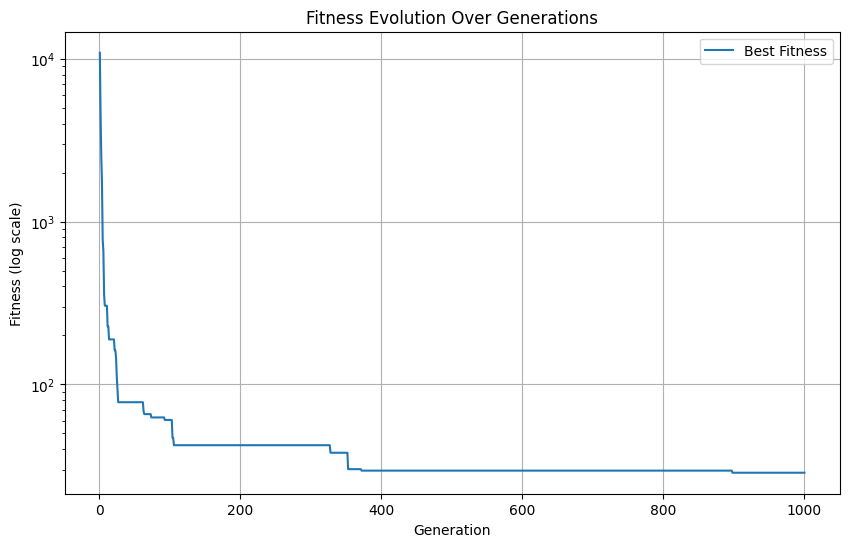

Best Solution: [-0.2677354791327416, 0.19529228875121102, -0.008408252991929502, -0.13005128929359622, -0.007689103510182982, -0.003349237623826342, 0.05168637080348087, -0.0722609271211145, 0.11314910196868103, 0.1006097607680728, 0.000537198527413775, 0.04848981752905574, 0.09416774558919633, -0.07210336001078214, 0.07357344677621686, 0.07379857433886565, 0.020745706624485265, -0.05032822206821154, 0.08902156042148787, 0.02621880138111722], Best Fitness: 28.702078309416958


In [68]:
m = 100
l = 80000
t = np.log(5)
t0 = np.log(2)
d = 20
T = 1000
lower_bound=-5
upper_bound=10
best_solution, best_fitness = ES_2(m, l, t, d, t0, rosenbrock_function, T, random_population_rosenbrock, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

Generation 1, Best Fitness: 22785.653235175672
Generation 2, Best Fitness: 10451.660237284917
Generation 3, Best Fitness: 6768.732065643755
Generation 4, Best Fitness: 2828.3336267298973
Generation 5, Best Fitness: 1718.0218177525585
Generation 6, Best Fitness: 722.6607264296733
Generation 7, Best Fitness: 492.91314449054727
Generation 8, Best Fitness: 263.6773166610102
Generation 9, Best Fitness: 263.6773166610102
Generation 10, Best Fitness: 263.6773166610102
Generation 11, Best Fitness: 263.6773166610102
Generation 12, Best Fitness: 263.6773166610102
Generation 13, Best Fitness: 263.6773166610102
Generation 14, Best Fitness: 263.6773166610102
Generation 15, Best Fitness: 263.6773166610102
Generation 16, Best Fitness: 263.6773166610102
Generation 17, Best Fitness: 263.6773166610102
Generation 18, Best Fitness: 263.6773166610102
Generation 19, Best Fitness: 138.2996233779914
Generation 20, Best Fitness: 138.2996233779914
Generation 21, Best Fitness: 133.70174115582324
Generation 22, B

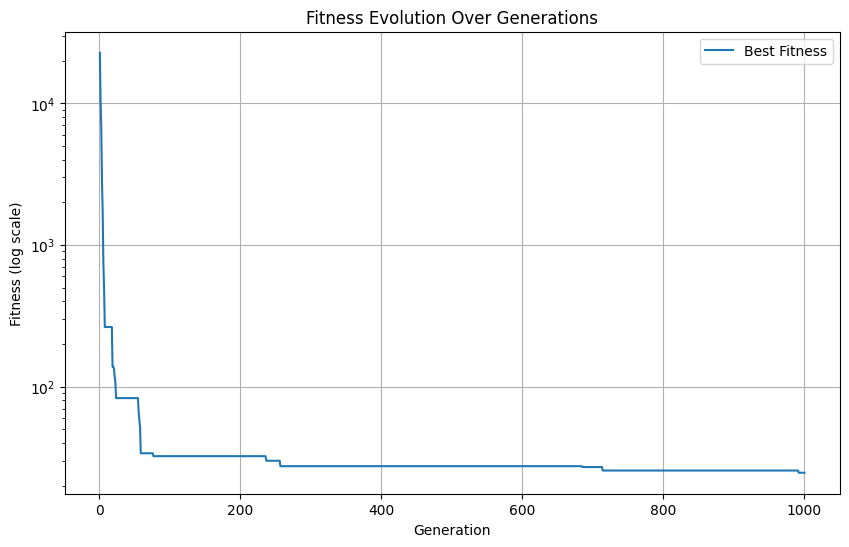

Best Solution: [0.31511288397060516, 0.007079967998165342, 0.04648434184092057, 0.03305454025053491, 0.15080502475757854, -0.04616519066428666, 0.0766627501861615, -0.012790081912164429, 0.0943819052977597, 0.019714342527309626, 0.017659052497295, 0.05108527145731638, -0.02576388604375947, -0.004563241630875898, 0.10791751155724917, 0.05963874568442433, -0.00664063425226482, 0.027705881528365235, 0.029183990547866544, 0.02842605542640408], Best Fitness: 24.65858303042755


In [70]:
def random_population_rosenbrock(m, d, lower_bound=-5, upper_bound=10):
    population = [[random.uniform(lower_bound, upper_bound) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 10) for _ in range(d)] for _ in range(m)]
    return [population, sigma]

m = 100
l = 80000
t = np.log(50)
t0 = np.log(20)
d = 20
T = 1000
lower_bound=-5
upper_bound=10
best_solution, best_fitness = ES_2(m, l, t, d, t0, rosenbrock_function, T, random_population_rosenbrock, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

### DIXON_PRICE

Generation 1, Best Function Value: 12830.738516889227
Generation 2, Best Function Value: 12830.738516889227
Generation 3, Best Function Value: 12830.738516889227
Generation 4, Best Function Value: 11407.78188594625
Generation 5, Best Function Value: 11407.78188594625
Generation 6, Best Function Value: 11407.78188594625
Generation 7, Best Function Value: 11407.78188594625
Generation 8, Best Function Value: 11407.78188594625
Generation 9, Best Function Value: 11304.542746442
Generation 10, Best Function Value: 8905.897710478728
Generation 11, Best Function Value: 8905.897710478728
Generation 12, Best Function Value: 7689.095282355281
Generation 13, Best Function Value: 7689.095282355281
Generation 14, Best Function Value: 7689.095282355281
Generation 15, Best Function Value: 7465.674285058338
Generation 16, Best Function Value: 7465.674285058338
Generation 17, Best Function Value: 7465.674285058338
Generation 18, Best Function Value: 6691.1940003388245
Generation 19, Best Function Value:

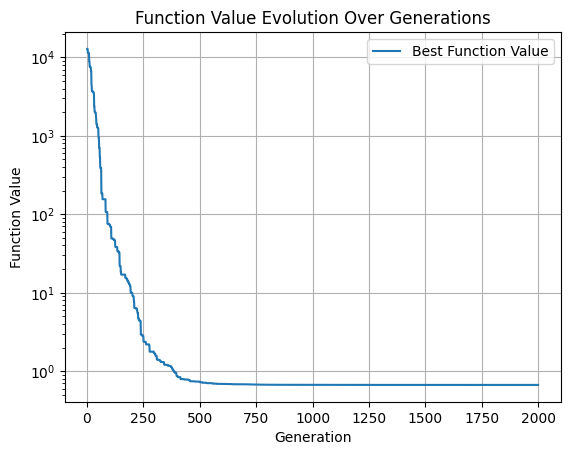

Best Solution: [0.3340939859008774, -0.0016536685293878173, -0.00010689034353231737, 0.0003909437425358184, -0.0013552537730219182, 2.7931440747872905e-05, 0.0009670445234316623, -6.062739684787726e-05, 0.00010102941552499249, 0.00023927387096293667, 0.015103720062274674, 0.08878531022520682, 0.21042964272915143, 0.32422627672179916, 0.40252426933280067, 0.44882003024593364, 0.47369415130248743, 0.4867066426214145, 0.49348892048868825, 0.49677110333943825], Best Fitness: 0.6667007591716819


In [56]:
def dixon_price_function(x):
    d = len(x)
    term1 = (x[0] - 1) ** 2
    term2 = 0.0
    for i in range(1, d):
        term2 += (i + 1) * (2 * x[i] ** 2 - x[i-1]) ** 2
    return term1 + term2

def random_population_dixon_price(m, d, lower_bound=-5, upper_bound=5):
    population = [[random.uniform(lower_bound, upper_bound) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 0.3) for _ in range(d)] for _ in range(m)]
    return [population, sigma]

m = 2000
l = 800
t = np.log(0.15)
t0 = np.log(0.7)
d = 20
T = 2000
lower_bound=-10
upper_bound=10

best_solution, best_fitness = ES_1(m, l, t, d, t0, dixon_price_function, T, random_population_dixon_price, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")


Generation 1, Best Fitness: 17255.829049260672
Generation 2, Best Fitness: 12367.394243040966
Generation 3, Best Fitness: 10830.683036771554
Generation 4, Best Fitness: 8309.192243865644
Generation 5, Best Fitness: 8029.154393054672
Generation 6, Best Fitness: 7900.360268747738
Generation 7, Best Fitness: 7746.231459447457
Generation 8, Best Fitness: 7059.728632612968
Generation 9, Best Fitness: 6837.448004490895
Generation 10, Best Fitness: 6751.588790570412
Generation 11, Best Fitness: 6591.933241270858
Generation 12, Best Fitness: 6591.933241270858
Generation 13, Best Fitness: 6591.933241270858
Generation 14, Best Fitness: 6591.933241270858
Generation 15, Best Fitness: 6591.933241270858
Generation 16, Best Fitness: 5517.326605262494
Generation 17, Best Fitness: 5450.338786040657
Generation 18, Best Fitness: 5306.613900738189
Generation 19, Best Fitness: 5272.227375082034
Generation 20, Best Fitness: 5214.944602777217
Generation 21, Best Fitness: 3170.6127926680215
Generation 22, Bes

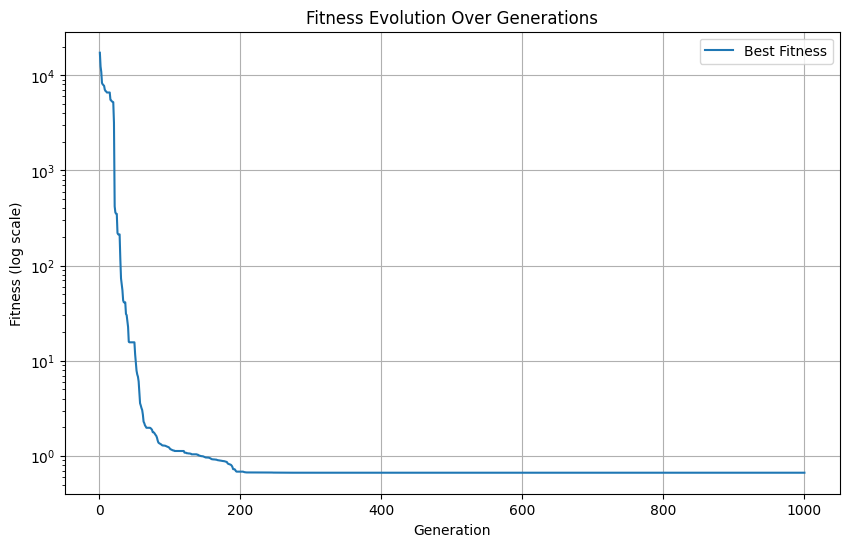

Best Solution: [0.3325820777669691, 0.0008799474573501683, -8.583477324058155e-05, -0.00022651021708449635, 0.00027882396103360863, 0.00025199967552256463, -0.00027310149770375596, 0.0002627974511530314, -0.00034175918531776885, 5.731136743973674e-05, 0.00013448389091575417, 0.00014418880229492674, 0.005880573630773856, 0.0528683531393697, 0.16231240922750587, 0.2848403432899217, 0.3775133742154772, 0.4343581199176232, 0.4660561035028916, 0.4827970029854392], Best Fitness: 0.6666758274733202


In [81]:
m = 100
l = 800
t = np.log(0.15)
t0 = np.log(0.45)
d = 20
T = 1000
lower_bound=-10
upper_bound=10

best_solution, best_fitness = ES_2(m, l, t, d, t0, dixon_price_function, T, random_population_dixon_price, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

Generation 1, Best Function Value: 450.00981447387267
Generation 2, Best Function Value: 450.00981447387267
Generation 3, Best Function Value: 450.00981447387267
Generation 4, Best Function Value: 450.00981447387267
Generation 5, Best Function Value: 433.9730658550759
Generation 6, Best Function Value: 433.9730658550759
Generation 7, Best Function Value: 433.9730658550759
Generation 8, Best Function Value: 433.9730658550759
Generation 9, Best Function Value: 419.45051031047444
Generation 10, Best Function Value: 414.0217201886208
Generation 11, Best Function Value: 385.601337666055
Generation 12, Best Function Value: 385.601337666055
Generation 13, Best Function Value: 385.601337666055
Generation 14, Best Function Value: 330.9244035138607
Generation 15, Best Function Value: 277.2150476966907
Generation 16, Best Function Value: 277.2150476966907
Generation 17, Best Function Value: 277.2150476966907
Generation 18, Best Function Value: 277.2150476966907
Generation 19, Best Function Value:

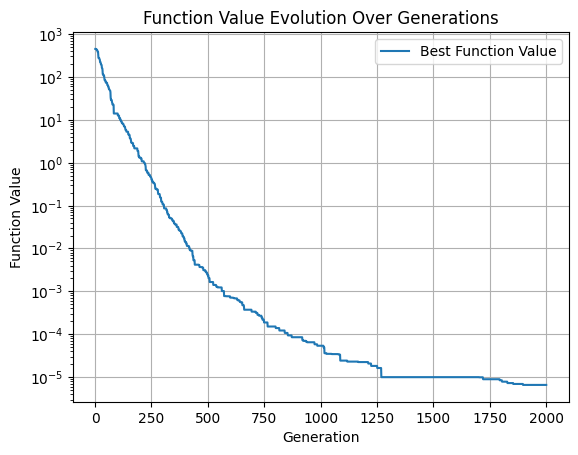

Best Solution: [-0.00011102819668806888, 0.0002915875699625015, 0.0002688298211648997, 0.0002673186711947262, 0.00022105818910884265, 7.480114782842149e-06, 0.00014310895906533239, -0.00015472077207323874, 0.0003044767320046184, -3.1772576705583686e-05, -0.00014164013193813992, 3.69694786624872e-05, 7.20480659414443e-05, -6.833589268275061e-05, -0.000257940829911232, -0.00015975976886181955, -0.0002997051714580637, -0.00023626599047383727, -6.197742151375316e-05, -6.070517689584203e-05], Best Fitness: 6.563790552582334e-06


In [55]:
def sum_of_squares_function(x):
    return sum((i + 1) * x[i] ** 2 for i in range(len(x)))

def random_population_sum_of_squares(m, d, lower_bound=-5, upper_bound=5):
    population = [[random.uniform(lower_bound, upper_bound) for _ in range(d)] for _ in range(m)]
    sigma = [[random.uniform(0.1, 0.3) for _ in range(d)] for _ in range(m)]
    
    return population, sigma


m = 1000
l = 800
t = np.log(0.15)
t0 = np.log(0.7)
d = 20
T = 2000
lower_bound=-10
upper_bound=10

best_solution, best_fitness = ES_1(m, l, t, d, t0, sum_of_squares_function, T, random_population_sum_of_squares, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

Generation 1, Best Fitness: 243.30863439590487
Generation 2, Best Fitness: 134.38684160309774
Generation 3, Best Fitness: 84.64990007425021
Generation 4, Best Fitness: 84.64990007425021
Generation 5, Best Fitness: 44.48791240580415
Generation 6, Best Fitness: 44.48791240580415
Generation 7, Best Fitness: 22.241459856651048
Generation 8, Best Fitness: 22.241459856651048
Generation 9, Best Fitness: 22.241459856651048
Generation 10, Best Fitness: 22.241459856651048
Generation 11, Best Fitness: 22.241459856651048
Generation 12, Best Fitness: 21.721523650650397
Generation 13, Best Fitness: 16.382809311928963
Generation 14, Best Fitness: 5.6898233887251815
Generation 15, Best Fitness: 5.631571463764836
Generation 16, Best Fitness: 4.553388553998265
Generation 17, Best Fitness: 2.7786557016333338
Generation 18, Best Fitness: 2.348460750405927
Generation 19, Best Fitness: 2.348460750405927
Generation 20, Best Fitness: 2.348460750405927
Generation 21, Best Fitness: 2.348460750405927
Generation 

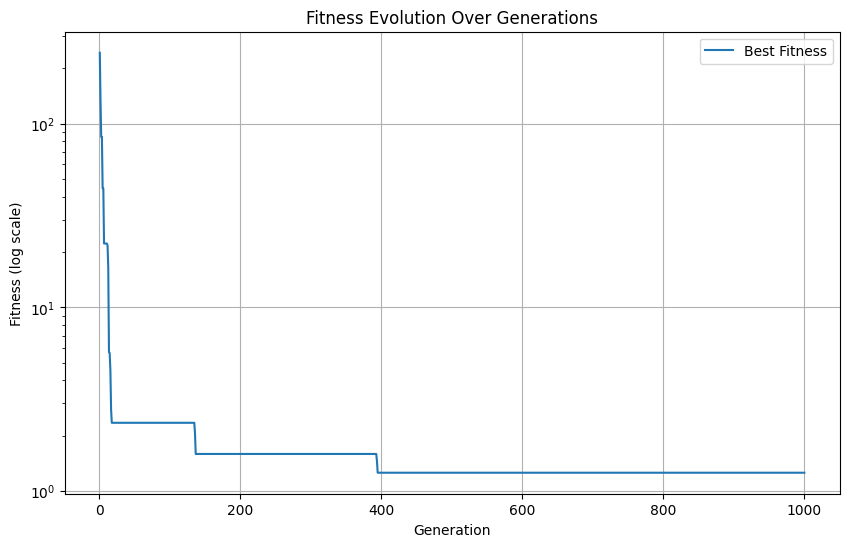

Best Solution: [0.007677007084868073, -0.11910812833202132, -0.0686015496041141, 0.18336852532405168, 0.14406616101014694, -0.07939919310555267, 0.01884359615609552, -0.07846185578848187, 0.11304310944102454, -0.019888882863016582, 0.052398430931715666, -0.11868331036538748, 0.040645299946052704, -0.026003770565516893, 0.04382379725054205, -0.09962498714408097, -0.1302134615909586, 0.023548809289357858, -0.04870103844996515, -0.016222130883627776], Best Fitness: 1.2556846837139217


In [54]:
m = 1000
l = 8000
t = np.log(0.002)
t0 = np.log(0.02)
d = 20
T = 1000
lower_bound=-10
upper_bound=10

best_solution, best_fitness = ES_2(m, l, t, d, t0, sum_of_squares_function, T, random_population_sum_of_squares, lower_bound, upper_bound)
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")